In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [48]:
def normalize(b, epsilon=1e-16):
    u = b / torch.sqrt((b * b).sum(1, keepdim=True)).clip(min=epsilon)
    return u

def truncated_proj_a_on_b(a,b, epsilon=1e-16):
    u = normalize(b, epsilon)
    prob_a_on_b = - torch.relu(- (a * u).sum(1, keepdim=True)) * u
    #a_proj_on_b = -torch.relu(- (a * u).sum(1, keepdim=True)) * u
    return a - prob_a_on_b


(-0.5890947471280372,
 0.45956748350448356,
 -0.04556142971249515,
 0.956790023962398)

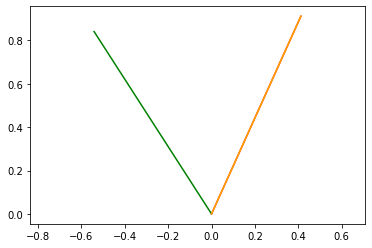

In [104]:
a = torch.tensor(np.random.randn(2)).unsqueeze(0)
b = torch.tensor(np.random.randn(2)).unsqueeze(0)

a = normalize(a)
b = normalize(b)
c = truncated_proj_a_on_b(a,b)

R = np.array([[0, -1], [1.,0]])
R = torch.tensor(R)

def plot_vector(vector, color):
    v = vector.squeeze(0).detach().cpu().numpy()
    plt.plot([0, v[0]], [0,v[1]], color=color)

plot_vector(a, "red")
plot_vector(b, "green")
plot_vector(c, "orange")

plt.axis('equal')
